# Assignment 2: 

# Paranoma Image Construction and Automatic Image Stitching by SIFT Matching and 2D Homography Estimation

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import random

# IMAGES

In [2]:
img_1a = r'E:\2022SP-CMP_SC-8690-01\Assignment 2\assignment2-pictures\assginment3-1b.png'
img_1b = r'E:\2022SP-CMP_SC-8690-01\Assignment 2\assignment2-pictures\assignment3-1a.png'
img_2a = r'E:\2022SP-CMP_SC-8690-01\Assignment 2\assignment2-pictures\assignment3-2b.png'
img_2b = r'E:\2022SP-CMP_SC-8690-01\Assignment 2\assignment2-pictures\assignment3-2a.png'
img_3a = r'E:\2022SP-CMP_SC-8690-01\Assignment 2\assignment2-pictures\assignment3-3b.png'
img_3b = r'E:\2022SP-CMP_SC-8690-01\Assignment 2\assignment2-pictures\assignment3-3a.png'

In [3]:
images = [img_1a,img_1b,img_2a,img_2b,img_3a,img_3b]

# CODE

In [23]:
img_left = cv2.imread(images[0])
img_left_bw = cv2.cvtColor(cv2.imread(images[0]),cv2.COLOR_BGR2GRAY)
img_right = cv2.imread(images[1])
img_right_bw = cv2.cvtColor(cv2.imread(images[1]),cv2.COLOR_BGR2GRAY)

## SIFT Points

In [38]:
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_left_bw,None)
kp2, des2 = sift.detectAndCompute(img_right_bw,None)

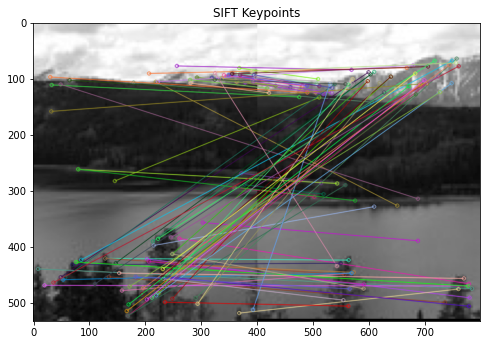

In [54]:
bf = cv2.BFMatcher(crossCheck = True)
_matches = bf.match(des2, des1)
matches_ = sorted(_matches, key = lambda x:x.distance)

plt.figure(figsize=(8,8))
img3 = cv2.drawMatches(img_right_bw,kp2,
                       img_left_bw,kp1,
                       matches_,None, flags=2)
plt.imshow(img3), plt.title('SIFT Keypoints')
plt.show()

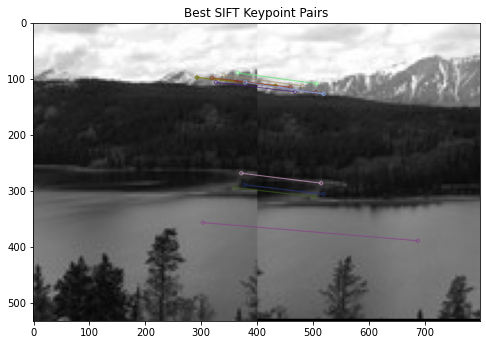

In [57]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des2, des1, k=2)

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

           
plt.figure(figsize=(8,8))
img3 = cv2.drawMatchesKnn(img_right_bw,kp2,
                           img_left_bw,kp1,
                          good, None, flags = 2)
plt.imshow(img3), plt.title('Best SIFT Keypoint Pairs')
plt.show()

In [58]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
matches = np.asarray(good)

correspondenceList=[]
for match in matches[:,0]:
    (x1, y1) = kp1[match.queryIdx].pt
    (x2, y2) = kp2[match.trainIdx].pt
    correspondenceList.append([x1, y1, x2, y2])
corrs = np.matrix(correspondenceList)

## Homography Estimation

In [59]:
def calcHomography(corrs):
    aList = []
    for corr in corrs:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])
        
        a1 = [-p1.item(0), -p1.item(1), -1, 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        
        a2 = [0, 0, 0, -p1.item(0), -p1.item(1), -1,
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)
    u, s, v = np.linalg.svd(matrixA)

    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h
    return h

In [60]:
def errors_calc(corrs, h):

    p1 = np.transpose(np.matrix([corrs[0].item(0), corrs[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([corrs[0].item(2), corrs[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [61]:
def HomographyRANSAC(corr, thresh):
    inliers_max = []
    H = None
    for i in range(5000):
        #find 4 random points to calculate a homography
        number_of_rows = corr.shape[0]
        random_indices = np.random.choice(number_of_rows, size=4, replace=False)
        random_rows = corr[random_indices, :]

        #call the homography function on those points
        h = calcHomography(random_rows)
        inliers = []

        for i in range(len(corr)):
            d = errors_calc(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(inliers_max):
            inliers_max = inliers
            H = h
        
        if len(inliers_max) > (len(corr)*thresh):
            break
    return H, inliers_max

In [62]:
H, inliers = HomographyRANSAC(corrs, 0.8)

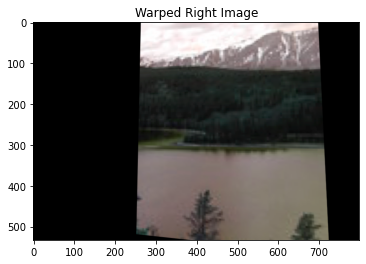

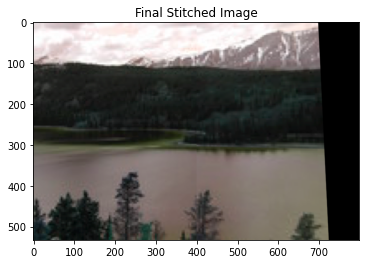

In [63]:
dst = cv2.warpPerspective(img_left,H,(img_right.shape[1] + img_left.shape[1], img_right.shape[0]))

plt.imshow(dst),plt.title('Warped Right Image')
plt.show()
plt.figure()
dst[0:img_right.shape[0], 0:img_right.shape[1]] = img_right

plt.imshow(dst),plt.title('Final Stitched Image')
plt.show()

# cv2.imwrite('output.jpg',dst)

# Panorama Stitching all images

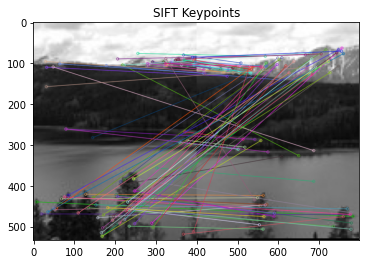

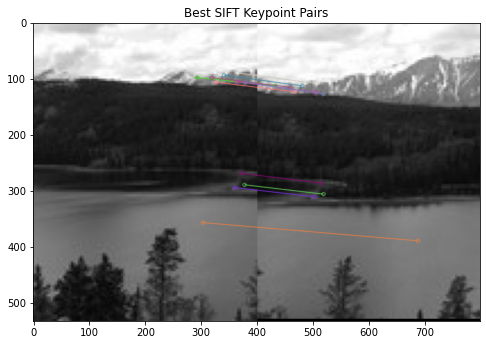

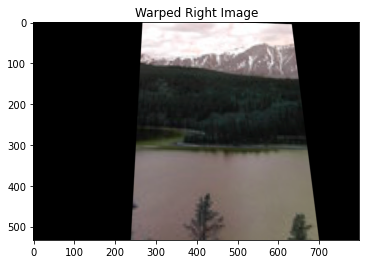

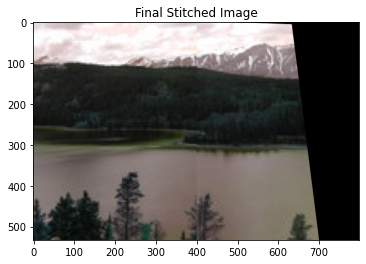

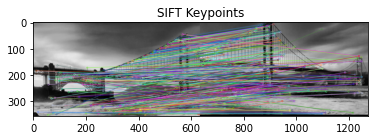

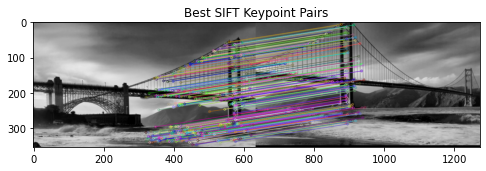

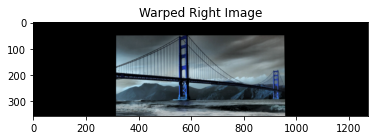

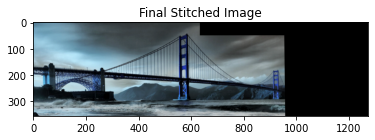

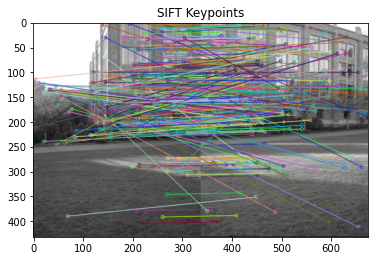

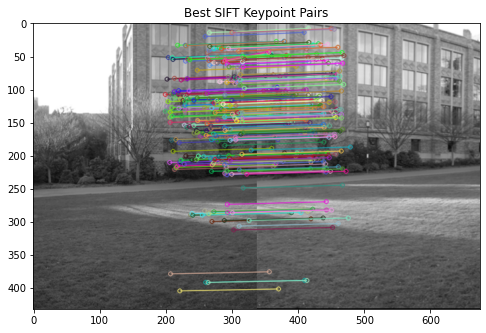

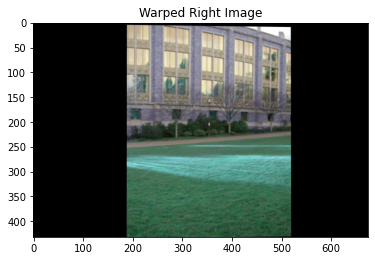

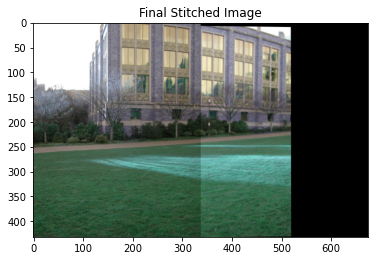

In [67]:
for i in range(0,len(images),2):
    img_left = cv2.imread(images[i])
    img_left_bw = cv2.cvtColor(cv2.imread(images[i]),cv2.COLOR_BGR2GRAY)
    img_right = cv2.imread(images[i+1])
    img_right_bw = cv2.cvtColor(cv2.imread(images[i+1]),cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img_left_bw,None)
    kp2, des2 = sift.detectAndCompute(img_right_bw,None)

    bf = cv2.BFMatcher(crossCheck = True)
    _matches = bf.match(des2, des1)
    matches_ = sorted(_matches, key = lambda x:x.distance)

    img3 = cv2.drawMatches(img_right_bw,kp2,
                           img_left_bw,kp1,
                           matches_,None, flags=2)
    plt.imshow(img3), plt.title('SIFT Keypoints')
    
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des2, des1, k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good.append([m])


    plt.figure(figsize=(8,8))
    img3 = cv2.drawMatchesKnn(img_right_bw,kp2,
                               img_left_bw,kp1,
                              good, None, flags = 2)
    plt.imshow(img3), plt.title('Best SIFT Keypoint Pairs')
    plt.show()
    
    matches = bf.knnMatch(des1,des2, k=2)

    good = []
    for m in matches:
        if m[0].distance < 0.5*m[1].distance:
            good.append(m)
    matches = np.asarray(good)
    
    correspondenceList=[]
    for match in matches[:,0]:
        (x1, y1) = kp1[match.queryIdx].pt
        (x2, y2) = kp2[match.trainIdx].pt
        correspondenceList.append([x1, y1, x2, y2])
    corrs = np.matrix(correspondenceList)
    
    H, inner = HomographyRANSAC(corrs, 0.8)
    
    dst = cv2.warpPerspective(img_left,H,(img_right.shape[1] + img_left.shape[1], img_right.shape[0]))

    plt.imshow(dst),plt.title('Warped Right Image')
    plt.show()
    plt.figure()
    dst[0:img_right.shape[0], 0:img_right.shape[1]] = img_right

    plt.imshow(dst),plt.title('Final Stitched Image')
    plt.show()